In [1]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
### Set up the pauli ops
I,X,Y,Z = np.matrix([[1,0],[0,1]]),np.matrix([[0,1],[1,0]]),np.matrix([[0,-1j],[1j,0]]),np.matrix([[1,0],[0,-1]])
[X0,Y0,Z0] = [np.kron(op,I) for op in [X,Y,Z]]
[X1,Y1,Z1] = [np.kron(I,op) for op in [X,Y,Z]]

In [3]:
from scipy.linalg import expm
def evolve(pulses, dt, H0, H_ops):
    """
    Compute the operator associated with a set of pulses
    
    (List[List[Float]]) pulses: The pulses. Each element should have length equal length
    (Float) dt: duration of each pulse
    (np.matrix) H0: The drift Hamiltonian
    (List[np.matrix]) H_ops: The control Hamiltonians.
    """
    U = np.identity(len(H0))
    for i in range(len(pulses[0])): 
        H = H0
        for k in range(len(pulses)):
            H = H + pulses[k][i] * H_ops[k]
        U=expm(-1j * dt * H) @ U
    return U
def getFidelity(dt, H0, H_ops,target):
    """
    Get an optimizable fidelity function for a set of pulses
    (Float) dt: Time increment
    (np.matrix) H0: The drift Hamiltonian
    (List[np.matrix]) H_ops: The control Hamiltonians.
    (np.matrix) target: The target state
    """
    def loss(coeffs):
        global iterations
        pulses = np.split(coeffs,len(H_ops))
        U=evolve(pulses, dt, H0, H_ops)
        fidelity = np.abs(np.trace(U.conjugate().transpose()@target))/len(target)
        return  -1 * fidelity 
    return loss 

In [4]:
import scipy
###Control and drift
H_ops = [Z0,X0,Y1,Z0@X1]
H_labels = [r'$Z_{0}$', r'$X_{0}$', r'$Y_{1}$', r'$Z_{0}X_1$']
H0 = Z0+Z1
CNOT = [[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]]

T=2*np.pi
N = 10 #number of individual steps
dt  = T/N #time interval for each step

u0 = np.random.rand(N*len(H_ops)) * 2 * np.pi * 0.05 #make a random array to start out
u0=np.convolve(np.ones(10)/10, u0,mode='same') #smooths the input
result = scipy.optimize.minimize(fun = getFidelity(dt=dt, H0=H0, H_ops=H_ops,target=CNOT)
                    ,x0=u0, bounds = [[-10,10]]*N*len(H_ops)
                 )
print("CNOT Fidelity: "+str(-1 * result.fun))

CNOT Fidelity: 0.9999999363422463


In [5]:
###The parameterized lookup table we want
def excitation(theta):
    return expm(1j * theta/2 * (X0@ Y1 - Y0 @ X1))

In [6]:
T=2*np.pi
N = 10 #number of individual steps
dt  = T/N #time interval for each step

coefficients = []
fidelities = []
for theta in np.linspace(0,2*np.pi,20):
    u0 = np.random.rand(N*len(H_ops)) * 2 * np.pi * 0.05 #make a random array to start out
    u0=np.convolve(np.ones(10)/10, u0,mode='same') #smooths the input
    result = scipy.optimize.minimize(fun = getFidelity(dt=dt, H0=H0, H_ops=H_ops,target=excitation(theta))
                        ,x0=u0
                     )
    coefficients.append(result.x)
    fidelities.append(-1*result.fun)
    print("Angle "+str(theta)+" completed with fidelity "+str(-1 * result.fun))

Angle 0.0 completed with fidelity 0.9999999843231572
Angle 0.3306939635357677 completed with fidelity 0.9999999999790231
Angle 0.6613879270715354 completed with fidelity 0.9999999999572534
Angle 0.992081890607303 completed with fidelity 0.9999999971337737
Angle 1.3227758541430708 completed with fidelity 0.9999999995585567
Angle 1.6534698176788385 completed with fidelity 0.9999999997601177
Angle 1.984163781214606 completed with fidelity 0.9999999994126492
Angle 2.3148577447503738 completed with fidelity 0.9999999996691065
Angle 2.6455517082861415 completed with fidelity 0.9999999998536683
Angle 2.9762456718219092 completed with fidelity 0.9999999978807664
Angle 3.306939635357677 completed with fidelity 0.9999999999625377
Angle 3.6376335988934447 completed with fidelity 0.9999999998065774
Angle 3.968327562429212 completed with fidelity 0.9999999998855224
Angle 4.29902152596498 completed with fidelity 0.9999999997900018
Angle 4.6297154895007475 completed with fidelity 0.9999999999043265
A

In [7]:
coefficients = np.array(coefficients)
def interpolate(theta,coefficients):
    coeffs = np.zeros(N*len(H_ops))
    for i in range(N*len(H_ops)):
        coeffs[i]=np.interp(x=theta,xp= np.linspace(0,2*np.pi,20),fp=coefficients.T[i])
    return coeffs

In [8]:
x=np.linspace(0,2*np.pi,1000)
y=[]
for i in x:
    y.append(-1 * getFidelity(dt, H0, H_ops,excitation(i))(interpolate(i,coefficients)))

Text(0, 0.5, 'fidelity')

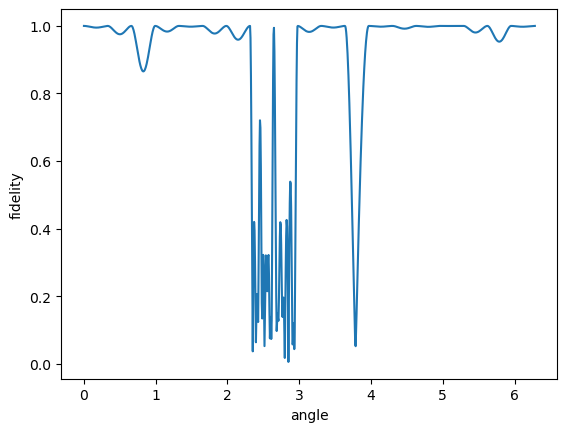

In [9]:
plt.plot(x,y)
plt.xlabel("angle")
plt.ylabel("fidelity")

In [10]:
mean_coeffs = np.mean(coefficients,axis=0)

def getLossFidelity(dt, H0, H_ops,target,mean):
    """
    Get an optimizable fidelity function for a set of pulses
    (Float) dt: Time increment
    (np.matrix) H0: The drift Hamiltonian
    (List[np.matrix]) H_ops: The control Hamiltonians.
    (np.matrix) target: The target state
    """
    def loss(coeffs):
        global iterations
        pulses = np.split(coeffs,len(H_ops))
        U=evolve(pulses, dt, H0, H_ops)
        fidelity = np.abs(np.trace(U.conjugate().transpose()@target))/len(target)
        return  1 - 1 * fidelity + 0.1 * np.linalg.norm(coeffs - mean)
    return loss 

In [11]:
new_coefficients = []
new_fidelities = []
for theta in np.linspace(0,2*np.pi,20):
    u0 = np.random.rand(N*len(H_ops)) * 2 * np.pi * 0.05 #make a random array to start out
    u0=np.convolve(np.ones(10)/10, u0,mode='same') #smooths the input
    result = scipy.optimize.minimize(fun = getLossFidelity(dt=dt, H0=H0, H_ops=H_ops,target=excitation(theta),mean=mean_coeffs)
                        ,x0=u0
                     )
    new_coefficients.append(result.x)
    new_fidelities.append(-1*result.fun)
    print("------------")
    print("Angle "+str(theta))
    print("Loss "+str(result.fun))
    f=-1 * getFidelity(dt=dt, H0=H0, H_ops=H_ops,target=excitation(theta))(result.x)
    print("Fidelity "+str(f))


------------
Angle 0.0
Loss 0.0872205945563739
Fidelity 0.9872516606660668
------------
Angle 0.3306939635357677
Loss 0.10296534798896623
Fidelity 0.9837068425977402
------------
Angle 0.6613879270715354
Loss 0.12923498837396521
Fidelity 0.9850993558827579
------------
Angle 0.992081890607303
Loss 0.15428160110461328
Fidelity 0.9857458630510472
------------
Angle 1.3227758541430708
Loss 0.16749734435203634
Fidelity 0.9870775834070085
------------
Angle 1.6534698176788385
Loss 0.16732372201610338
Fidelity 0.9910084170802467
------------
Angle 1.984163781214606
Loss 0.16207636876602266
Fidelity 0.9913638460211853
------------
Angle 2.3148577447503738
Loss 0.1498886037354401
Fidelity 0.9937358750935865
------------
Angle 2.6455517082861415
Loss 0.15585899139182827
Fidelity 0.9920174627362618
------------
Angle 2.9762456718219092
Loss 0.15120488491215253
Fidelity 0.9943436276136731
------------
Angle 3.306939635357677
Loss 0.15298452988956943
Fidelity 0.9949046231827173
------------
Angle 

In [12]:
new_coefficients = np.array(new_coefficients)

In [13]:
x=np.linspace(0,2*np.pi,1000)
y=[]
for i in x:
    y.append(-1 * getFidelity(dt, H0, H_ops,excitation(i))(interpolate(i,new_coefficients)))

Text(0, 0.5, 'fidelity')

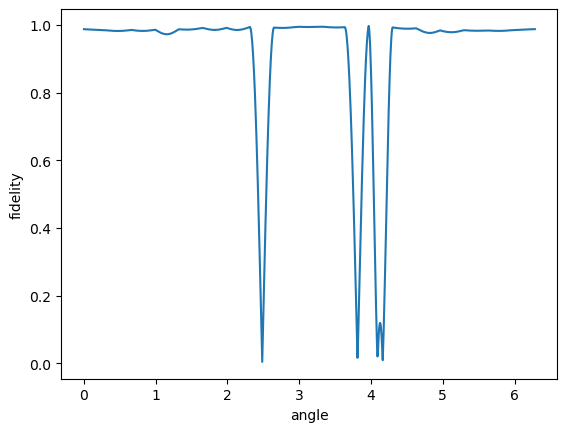

In [14]:
plt.plot(x,y)
plt.xlabel("angle")
plt.ylabel("fidelity")

In [15]:
mean_coeffs = np.mean(new_coefficients,axis=0)
newer_coefficients = []
newer_fidelities = []
for theta in np.linspace(0,2*np.pi,20):
    u0 = np.random.rand(N*len(H_ops)) * 2 * np.pi * 0.05 #make a random array to start out
    u0=np.convolve(np.ones(10)/10, u0,mode='same') #smooths the input
    result = scipy.optimize.minimize(fun = getLossFidelity(dt=dt, H0=H0, H_ops=H_ops,target=excitation(theta),mean=mean_coeffs)
                        ,x0=u0
                     )
    newer_coefficients.append(result.x)
    newer_fidelities.append(-1*result.fun)
    print("------------")
    print("Angle "+str(theta))
    print("Loss "+str(result.fun))
    f=-1 * getFidelity(dt=dt, H0=H0, H_ops=H_ops,target=excitation(theta))(result.x)
    print("Fidelity "+str(f))


------------
Angle 0.0
Loss 0.08692080903993224
Fidelity 0.9889851779105582
------------
Angle 0.3306939635357677
Loss 0.09701513259187147
Fidelity 0.9879963379631842
------------
Angle 0.6613879270715354
Loss 0.11582445736525455
Fidelity 0.9879270612599943
------------
Angle 0.992081890607303
Loss 0.13593011852976983
Fidelity 0.9878555650684518
------------
Angle 1.3227758541430708
Loss 0.1485616253197349
Fidelity 0.9883398680447075
------------
Angle 1.6534698176788385
Loss 0.14911364153153364
Fidelity 0.9912244986984036
------------
Angle 1.984163781214606
Loss 0.14370293220633826
Fidelity 0.9923257000683897
------------
Angle 2.3148577447503738
Loss 0.13496206143190753
Fidelity 0.9942382730516491
------------
Angle 2.6455517082861415
Loss 0.14638957878397002
Fidelity 0.99382995919581
------------
Angle 2.9762456718219092
Loss 0.14709280014464107
Fidelity 0.9946819655966437
------------
Angle 3.306939635357677
Loss 0.14969006534446333
Fidelity 0.9955110548856345
------------
Angle 3

In [26]:
newer_coefficients = np.array(newer_coefficients)
x=np.linspace(0,2*np.pi,1000)
y=[]
for i in x:
    y.append(-1 * getFidelity(dt, H0, H_ops,excitation(i))(interpolate(i,newer_coefficients)))

Text(0, 0.5, 'fidelity')

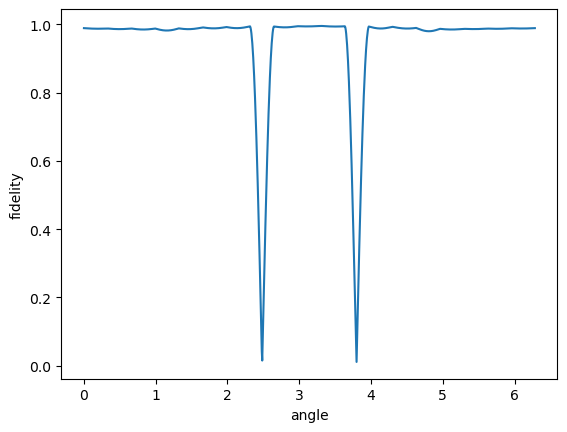

In [27]:
plt.plot(x,y)
plt.xlabel("angle")
plt.ylabel("fidelity")

In [28]:
data = list(zip(x,y))
data.sort(key = lambda v : v[1])
data[:2]

[(3.7988427683047745, 0.011266475305964752),
 (2.4843425388748113, 0.01534173356359596)]

<Figure size 800x1200 with 0 Axes>

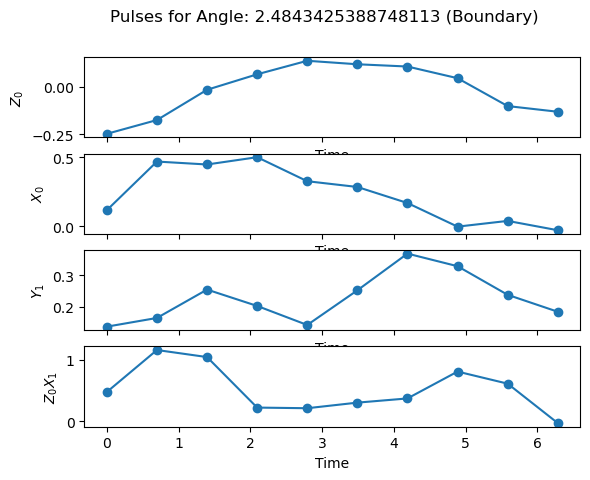

In [29]:
theta  =2.4843425388748113
coeffs = np.split(interpolate(theta,newer_coefficients),len(H_ops))
plt.figure(figsize=(8,12))
f, ax = plt.subplots(4, sharex=True)
f.suptitle('Pulses for Angle: '+str(theta) + " (Boundary)")
for i in range(4):
    ax[i].plot(np.linspace(0,2*np.pi,10),coeffs[i],'-o')
    ax[i].set(ylabel = H_labels[i],xlabel = 'Time')


<Figure size 800x1200 with 0 Axes>

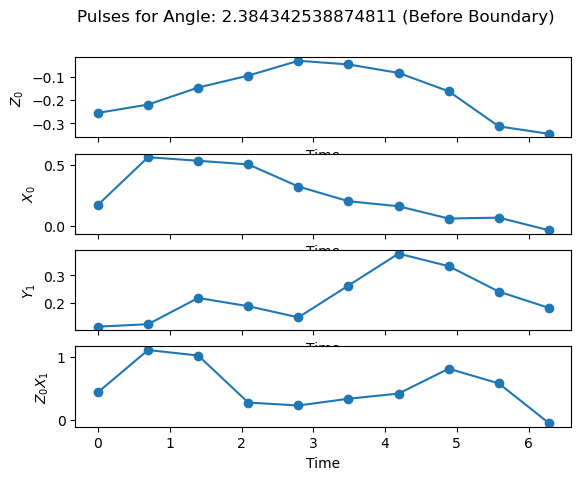

In [30]:
theta  =2.4843425388748113 - 0.1
coeffs = np.split(interpolate(theta,newer_coefficients),len(H_ops))
plt.figure(figsize=(8,12))
f, ax = plt.subplots(4, sharex=True)
f.suptitle('Pulses for Angle: '+str(theta) + " (Before Boundary)")
for i in range(4):
    ax[i].plot(np.linspace(0,2*np.pi,10),coeffs[i],'-o')
    ax[i].set(ylabel = H_labels[i],xlabel = 'Time')


<Figure size 800x1200 with 0 Axes>

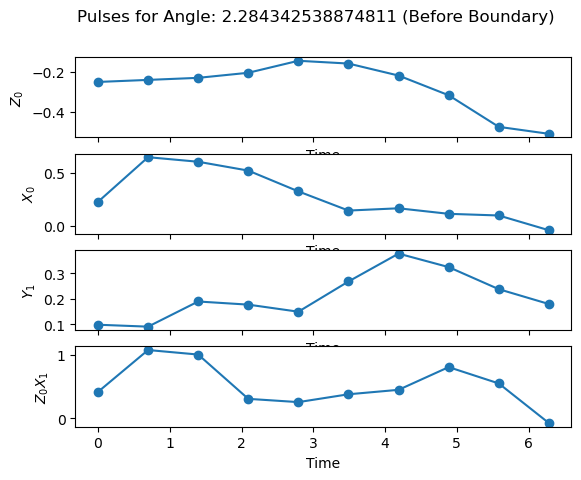

In [31]:
theta  =2.4843425388748113 - 0.2
coeffs = np.split(interpolate(theta,newer_coefficients),len(H_ops))
plt.figure(figsize=(8,12))
f, ax = plt.subplots(4, sharex=True)
f.suptitle('Pulses for Angle: '+str(theta) + " (Before Boundary)")
for i in range(4):
    ax[i].plot(np.linspace(0,2*np.pi,10),coeffs[i],'-o')
    ax[i].set(ylabel = H_labels[i],xlabel = 'Time')


<Figure size 800x1200 with 0 Axes>

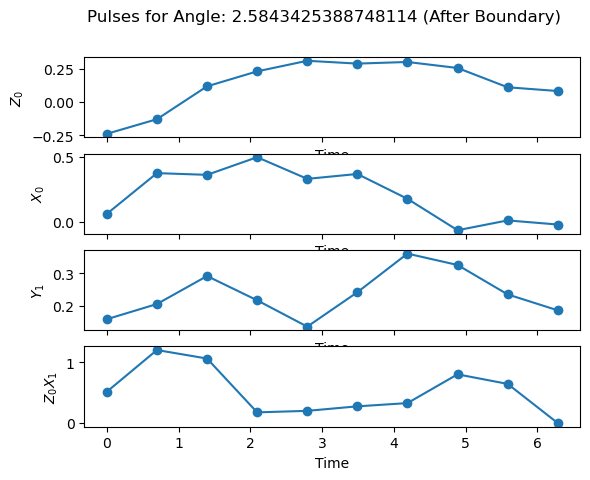

In [32]:
theta  =2.4843425388748113 + 0.1
coeffs = np.split(interpolate(theta,newer_coefficients),len(H_ops))
plt.figure(figsize=(8,12))
f, ax = plt.subplots(4, sharex=True)
f.suptitle('Pulses for Angle: '+str(theta) + " (After Boundary)")
for i in range(4):
    ax[i].plot(np.linspace(0,2*np.pi,10),coeffs[i],'-o')
    ax[i].set(ylabel = H_labels[i],xlabel = 'Time')


<Figure size 800x1200 with 0 Axes>

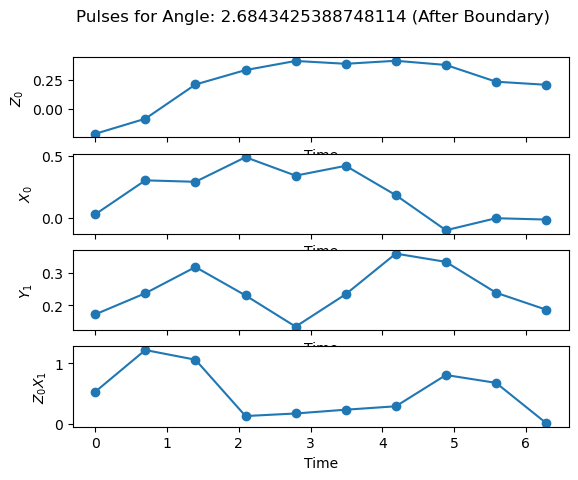

In [33]:
theta  =2.4843425388748113 + 0.2
coeffs = np.split(interpolate(theta,newer_coefficients),len(H_ops))
plt.figure(figsize=(8,12))
f, ax = plt.subplots(4, sharex=True)
f.suptitle('Pulses for Angle: '+str(theta) + " (After Boundary)")
for i in range(4):
    ax[i].plot(np.linspace(0,2*np.pi,10),coeffs[i],'-o')
    ax[i].set(ylabel = H_labels[i],xlabel = 'Time')


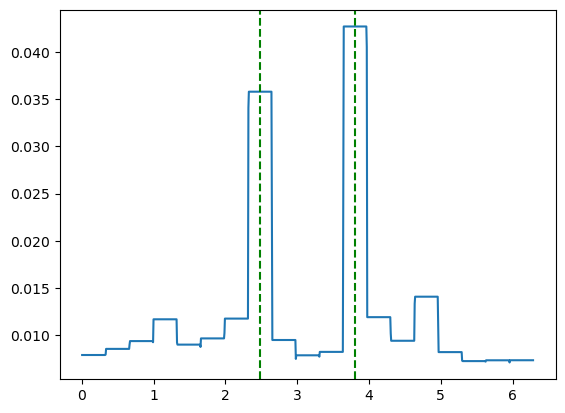

In [36]:
x=np.linspace(0,2*np.pi,1000)
y=[]
for i in range(1,len(x)):
    current = interpolate(x[i],newer_coefficients)
    prev =   interpolate(x[i-1],newer_coefficients)
    y.append(np.linalg.norm(current-prev))
plt.plot(x[1:],y)
plt.axvline(x=3.7988427683047745,color='g',linestyle = 'dashed')
plt.axvline(x=2.4843425388748113,color='g',linestyle = 'dashed')